# DTSA-5510 Week 4: BBC News Classification Kaggle Mini-Project
## Author: Alan Klein
## Create Date: 2025-04-27
github link: https://github.com/Saganoky/DTSA-5510-Week-4-Kaggle-Project


Compare with supervised learning [30 pts]

Use the following steps to guide your work:

1) Pick and train a supervised learning method(s) and compare the results (train and test performance)
2) Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?


Produce Deliverable: High-Quality, Organized Jupyter Notebook Report
This project gives you hands-on experience on Kaggle, a famous platform for data science competitions. To further your professional development, think of your peers as work colleagues. An essential part of this project is the Peer Review. 

Complete Part 2. 

Limitation(s) of sklearn’s non-negative matrix factorization library. [20 pts]

1. Load the movie ratings data (as in the HW3-recommender-system) and use matrix factorization technique(s) and predict the missing ratings from the test data. Measure the RMSE. You should use sklearn library. [10 pts]


2. Discuss the results and why sklearn's non-negative matrix facorization library did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it? [10 pts]

### Introduction
For this project I will be analyzing a dataset of BBC news documents, with the goal of categorizing them into one of 5 categories, business, entertainment, politics, sport or tech.  This is a Kaggle competition dataset.  More information can be found here: https://www.kaggle.com/c/learn-ai-bbc/overview[1]

Bijoy Bose. BBC News Classification. https://kaggle.com/competitions/learn-ai-bbc, 2019. Kaggle.

#### Problem Solved 
Being able to classify documents solves a number of problems.  For example imagine someone auditing a company, being able to quickly find the relevant documents could save hundreds of hours of work.  Another use would be to be able to identify documents sensitive in nature, to make sure they are filed with the required safegaurds in place.

### Setup
The code below imports all the required packages and sets up the kaggle API.  This repo uses UV to manage packages, see https://docs.astral.sh/uv/ for more information on how to use it.  Also, if you are not familiar with UV I highly recommend you check it out for package management. It fast and easy to use.  Also, from my experience it is being used more and more in industry.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, make_scorer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


In [3]:
# This sets up the kaggle API.  You need to have a kaggle account and a token to be able to run this code.  
# This video gives a pretty good explanation of how to get the token: https://www.youtube.com/watch?v=gkEbaMgvLs8&t=188s
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()


In [4]:
# Run these two commands to download and unzip the data sets into the data folder.
!kaggle competitions download -c learn-ai-bbc
!unzip learn-ai-bbc.zip -d data/

learn-ai-bbc.zip: Skipping, found more recently modified local copy (use --force to force download)
^C


### Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Please feel free to look at online resources on processing raw texts to feature vectors. Many methods process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a method and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words. Also, do exploratory data analysis such as word statistics and/or visualization.

As we did not learn natural language processing (NLP) specific techniques such as word embeddings in the lectures, we recommend reading discussions and example codes from others in the Kaggle and/or doing some research online to make sure you understand. You can refer to any resource as needed, but make sure you “demonstrate” your understanding- please include explaining in your own words, discussions, and your interpretation. Also importantly, please have a reference list at the end of the report.  

In [5]:
# Read in the data as dataframes
train = pd.read_csv('data/BBC News Train.csv')
test = pd.read_csv('data/BBC News Test.csv')
sample_solution = pd.read_csv('data/BBC News Sample Solution.csv')

In [6]:
# Look at the data
train.info

# It appears to be 3 columns - ArticleId, Text and Category.  The text is the article and the category is the label we want to predict. 

<bound method DataFrame.info of       ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  
0          business  
1          business  
2          business  
3              tech  
4          busine

In [7]:
# Check summary statistics of the train and test data
train.info()
test.info()

# One thing to note is that we don't have any nulls in the test or train data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


<Axes: xlabel='Category', ylabel='Count'>

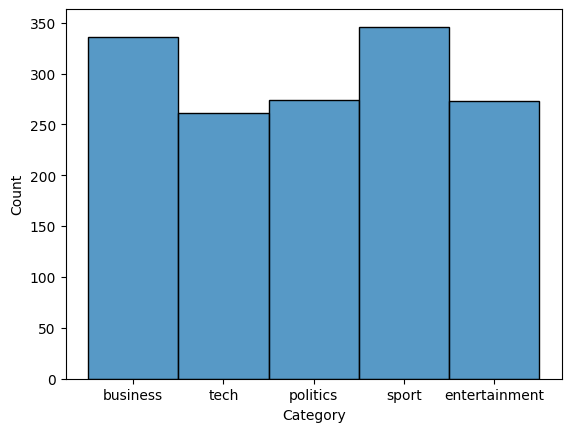

In [8]:
# Find how many articles of each category we have in the train data.
sns.histplot(train['Category'], bins=5)

# There is a relatively even distribution of articles across the categories.  So we don't have to worry about class imbalance.  

#

In [9]:
# Split the data into train and validation sets. 

X_train, X_val, y_train, y_val = train_test_split(train['Text'], train['Category'], test_size=0.2, random_state=42)

print()

#### TF-IDF
To vectorize the data I will use TfidfVectorizer from the sklearn library. TF-IDF stand for term frequency–inverse document frequency.  It is calculated as the product of 2 things TF and IDF.  TF is a measure of relative frequency.  Its calculated by counting the number of times a term appears in a document divided by the total number of terms in a document.  IDF is a measure of how common or rare a a word is across all documents.  This is calculated by taking the log of the total number of documents divided by the number of documents where the word appears.  By combining these two metrics together you get a high TF-IDF value when a word appears a lot in a single document but is relatively rare across all documents.  The theory behind why this calculation works is that it reduces the importance of very common words.[2]

In [10]:
# Implementing Tfidf using notes from problem solving with ML[3]

from sklearn.feature_extraction.text import TfidfVectorizer
def word_embeddings(X_data):
    # Strip accents, which are just extra characters, sublinear_tf makes is so the tf using a log scale, 
    # as words use zips law[3], stripping stop words, and using ngrams of 1 or 2 words.
    tfidf = TfidfVectorizer(strip_accents = 'unicode', sublinear_tf=True, ngram_range=(1, 2), stop_words='english')
    features = tfidf.fit_transform(X_data).toarray()
    return features, tfidf.get_feature_names_out(), tfidf


features, ngrams, vectorizer_model = word_embeddings(X_train)

# set to print out all of the vector
np.set_printoptions(threshold=np.inf)
# can uncomment below to see what one of the vectors looks like.  It is very sparse.
# print(features[0])

np.set_printoptions(threshold=20)
print(features)
print(ngrams)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['00' '00 minute' '00 work' ... 'zvonareva russia' 'zvonareva struggled'
 'zvonareva wimbledon']


C:\Users\ajkle\AppData\Local\Temp\ipykernel_17380\921378643.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'sum_TFIDF', y = 'ngram', data = Top_20_ngrams, palette = 'viridis')


<Axes: xlabel='sum_TFIDF', ylabel='ngram'>

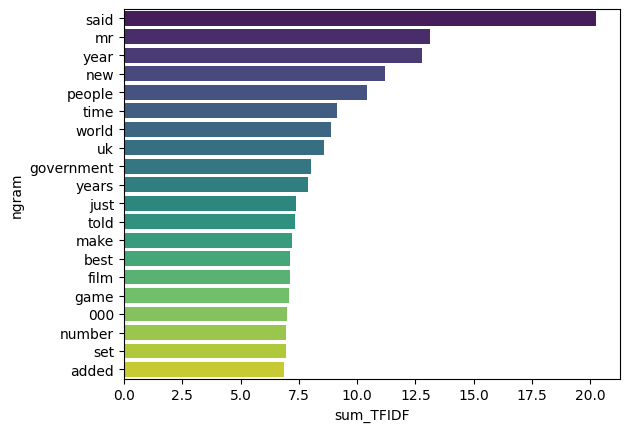

In [11]:
# top ten most impactful words based on TF-IDF

sum_features = np.sum(features, axis = 0)

Top_20_ngrams = pd.DataFrame({'ngram': ngrams, 'sum_TFIDF': sum_features}).sort_values(by = 'sum_TFIDF', ascending = False).head(20)

# Plot the top 20 ngrams
sns.barplot(x = 'sum_TFIDF', y = 'ngram', data = Top_20_ngrams, palette = 'viridis')

# the top 20 ngrams are interesting, some of them could be super informative such as government, others may be less so such as said.

### Building and training models. [35 pts]

In the Kaggle competition, the training data has labels (category). Thus, it can be solved using supervised learning. In general, the more labeled data we have, the more accurate the supervised learning model will be. But unsupervised learning can be powerful even when there is a small number of labels or no labels. This assignment will apply an unsupervised approach, especially the matrix factorization method, to discover topics in the news articles and use the labels to check the accuracy.

Here are some steps to guide this section: 
1) Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

    In this case, because you are predicting categories, it doesn't make sense to include word features from the test dataset.  You are building a model on the training data and applying it to the test data.

2) Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.

    Done

3) Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle. 


4) Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.

5) Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc. 

In [12]:

from sklearn.decomposition import NMF

nmf_model = NMF(n_components=5, random_state=1337)
W = nmf_model.fit_transform(features)
H = nmf_model.components_

print(W.shape)
print(H.shape)
print(ngrams.shape)
print(H)

(1192, 5)
(5, 208793)
(208793,)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.43057581e-03
  3.57772649e-03 3.57772649e-03]
 [1.57767980e-03 2.33558600e-04 1.41787863e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.37543720e-03 1.51030900e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.60696872e-04 0.00000000e+00 2.89939517e-04 ... 0.00000000e+00
  2.78939637e-05 2.78939637e-05]
 [1.72475758e-05 0.00000000e+00 9.19928200e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [13]:
# Look at top 20 words in each grouping

grouping = 1
for category in H:
    top_word_indexs = np.argsort(category)[:-20:-1]
    print('grouping:', grouping)
    for i in top_word_indexs:
        print(ngrams[i])
    grouping += 1



grouping: 1
game
england
win
cup
said
play
season
team
injury
match
time
world
final
coach
players
won
year
old
ireland
grouping: 2
mr
labour
election
blair
party
government
minister
mr blair
prime
prime minister
said
tories
brown
leader
howard
tony blair
tony
tory
lib
grouping: 3
people
mobile
users
technology
digital
phone
music
use
software
video
phones
said
net
microsoft
million
online
service
services
new
grouping: 4
film
best
awards
actor
award
oscar
actress
aviator
director
comedy
star
nominated
won
million dollar
dollar baby
films
nominations
best film
baby
grouping: 5
said
growth
economy
market
year
company
firm
bank
economic
shares
2004
oil
financial
deal
chief
analysts
government
business
sales


In [14]:
# Tool to match categories to labels giving the best accuracy score.  
import itertools

def label_permute_compare(labels,pred,n=5):
    label_factors = pd.factorize(labels)[0]
    pred_pd = pd.DataFrame(pred)
    best_acc = 0
    best_perm = None
   
    for perm in itertools.permutations(range(n)):
        perm_yp = pred_pd.replace(list(range(n)), list(perm))
        perm_acc = accuracy_score(label_factors, perm_yp)
        if perm_acc > best_acc:
            best_acc = perm_acc
            best_perm = perm
    return best_perm, best_acc, pd.factorize(labels)[1]


preds = np.argmax(W, axis = 1)
preds_and_labels = pd.DataFrame({'preds': preds, 'labels': y_train})

best_perm, best_acc, train_labs = label_permute_compare(preds_and_labels['labels'],preds_and_labels['preds'],n=5)
print("Best permutation:", best_perm)
print("Best accuracy:", best_acc)
print("Train labels:", train_labs)
print(preds_and_labels)



# vectorize test data
test_vecs = vectorizer_model.transform(X_val)

# transform test data using the NMF model
w_test = nmf_model.transform(test_vecs) 

test_preds = np.argmax(w_test, axis = 1)
test_preds_and_labels = pd.DataFrame({'preds': test_preds, 'labels': y_val})
test_best_perm, test_best_acc, test_labs = label_permute_compare(test_preds_and_labels['labels'],test_preds_and_labels['preds'],n=5)
print("Best permutation:", test_best_perm)
print("Best accuracy:", test_best_acc)
print("Test labels:", test_labs)
print(test_preds_and_labels)



Best permutation: (0, 2, 4, 3, 1)
Best accuracy: 0.9228187919463087
Train labels: Index(['sport', 'business', 'politics', 'entertainment', 'tech'], dtype='object')
      preds         labels
1166      0          sport
1106      4       business
538       1       politics
439       0          sport
1478      1       politics
...     ...            ...
1130      1       politics
1294      4       business
860       1       politics
1459      0  entertainment
1126      0          sport

[1192 rows x 2 columns]
Best permutation: (4, 1, 2, 0, 3)
Best accuracy: 0.9395973154362416
Test labels: Index(['entertainment', 'politics', 'tech', 'business', 'sport'], dtype='object')
      preds         labels
941       2  entertainment
297       1       politics
271       1       politics
774       2           tech
420       2           tech
...     ...            ...
1144      4       business
1309      1       business
1444      3  entertainment
949       2           tech
1212      3  entertainment


In [15]:
# Create a index to label mapping
index_to_labels = pd.DataFrame({'category_number': [0,4,1,3,2], 'category_name': pd.factorize(y_train)[1]})                  
print(index_to_labels)
print(preds_and_labels)
preds_and_labels_fixed = preds_and_labels.replace(list(index_to_labels['category_number']), list(index_to_labels['category_name']))

print(preds_and_labels_fixed)

print(confusion_matrix(preds_and_labels_fixed['labels'], preds_and_labels_fixed['preds']))

   category_number  category_name
0                0          sport
1                4       business
2                1       politics
3                3  entertainment
4                2           tech
      preds         labels
1166      0          sport
1106      4       business
538       1       politics
439       0          sport
1478      1       politics
...     ...            ...
1130      1       politics
1294      4       business
860       1       politics
1459      0  entertainment
1126      0          sport

[1192 rows x 2 columns]
         preds         labels
1166     sport          sport
1106  business       business
538   politics       politics
439      sport          sport
1478  politics       politics
...        ...            ...
1130  politics       politics
1294  business       business
860   politics       politics
1459     sport  entertainment
1126     sport          sport

[1192 rows x 2 columns]
[[251   0   4   0   6]
 [ 13 180   7   7  20]
 [ 13   0 201   

In [16]:
# Submit test to kaggle
# vectorize test data
test_vecs = vectorizer_model.transform(test['Text'])

# transform test data using the NMF model
w_test = nmf_model.transform(test_vecs) 

test_preds = np.argmax(w_test, axis = 1)

test_preds_replaced = pd.DataFrame({'pred': test_preds}).replace(list(index_to_labels['category_number']), list(index_to_labels['category_name']))


print(test['ArticleId'])
print(test_preds_replaced['pred'])

kaggle_df = pd.DataFrame({'ArticleId': np.array(test['ArticleId']), 'Category': test_preds_replaced['pred']})

# Make the final predictions and save them to a csv file

kaggle_df.to_csv('data/NMF_First_Submission.csv', index=False)

0      1018
1      1319
2      1138
3       459
4      1020
       ... 
730    1923
731     373
732    1704
733     206
734     471
Name: ArticleId, Length: 735, dtype: int64
0              sport
1               tech
2              sport
3           business
4              sport
           ...      
730         business
731    entertainment
732             tech
733         business
734         politics
Name: pred, Length: 735, dtype: object


In [ ]:
# Use this to submit the file to kaggle.
# !kaggle competitions submit -c learn-ai-bbc -f data\NMF_First_Submission.csv -m "1st NMF submission"

Successfully submitted to BBC News Classification



  0%|          | 0.00/9.82k [00:00<?, ?B/s]
100%|██████████| 9.82k/9.82k [00:00<00:00, 23.4kB/s]


#### First Kaggle Submission
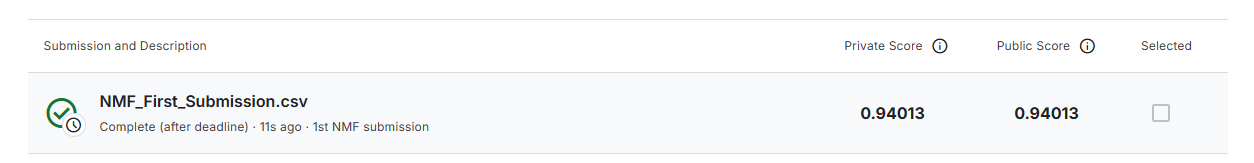

In [17]:
### Hyperparameter tuning

def word_embeddings(X_data, max_ngrams):
    # Strip accents, which are just extra characters, sublinear_tf makes is so the tf using a log scale, 
    # as words use zips law[3], stripping stop words, and using ngrams of 1 or 2 words.
    tfidf = TfidfVectorizer(strip_accents = 'unicode', sublinear_tf=True, ngram_range=(1, max_ngrams), stop_words='english')
    features = tfidf.fit_transform(X_data).toarray()
    return features, tfidf.get_feature_names_out(), tfidf

def create_nmf_model(feature_data, w_reg):
    nmf_model = NMF(n_components=5, random_state=1337, alpha_W = w_reg)
    W = nmf_model.fit_transform(feature_data)
    H = nmf_model.components_
    return W, H, nmf_model

def label_permute_compare(labels,W,n=5):
    pred = np.argmax(W, axis = 1)
    label_factors = pd.factorize(labels)[0]
    pred_pd = pd.DataFrame(pred)
    best_acc = 0
    best_perm = None
   
    for perm in itertools.permutations(range(n)):
        perm_yp = pred_pd.replace(list(range(n)), list(perm))
        perm_acc = accuracy_score(label_factors, perm_yp)
        if perm_acc > best_acc:
            best_acc = perm_acc
            best_perm = perm
    return best_perm, best_acc, pd.factorize(labels)[1]

def print_results(best_perm, best_acc, train_labs):
    print("Best permutation:", best_perm)
    print("Best accuracy:", best_acc)
    print("Train labels:", train_labs)

# Test regularization parameter
for w in [0, 0.5, 1]:
    features, ngrams, vectorizer_model = word_embeddings(X_train, max_ngrams=2)
    W, H, nmf_model = create_nmf_model(features, w_reg = w)
    best_perm, best_acc, train_labs = label_permute_compare(y_train,W,n=5)
    print("Regularization:", w)
    print_results(best_perm, best_acc, train_labs)
    # run on validation set
    val_vecs = vectorizer_model.transform(X_val)
    w_val = nmf_model.transform(val_vecs) 
    val_best_perm, val_best_acc, val_labs = label_permute_compare(y_val,w_val,n=5)
    print_results(val_best_perm, val_best_acc, val_labs)


Regularization: 0
Best permutation: (0, 2, 4, 3, 1)
Best accuracy: 0.9228187919463087
Train labels: Index(['sport', 'business', 'politics', 'entertainment', 'tech'], dtype='object')
Best permutation: (4, 1, 2, 0, 3)
Best accuracy: 0.9395973154362416
Train labels: Index(['entertainment', 'politics', 'tech', 'business', 'sport'], dtype='object')
Regularization: 0.5
Best permutation: (0, 2, 4, 3, 1)
Best accuracy: 0.2634228187919463
Train labels: Index(['sport', 'business', 'politics', 'entertainment', 'tech'], dtype='object')
Best permutation: (3, 0, 1, 2, 4)
Best accuracy: 0.2516778523489933
Train labels: Index(['entertainment', 'politics', 'tech', 'business', 'sport'], dtype='object')
Regularization: 1
Best permutation: (0, 2, 4, 3, 1)
Best accuracy: 0.2634228187919463
Train labels: Index(['sport', 'business', 'politics', 'entertainment', 'tech'], dtype='object')
Best permutation: (3, 0, 1, 2, 4)
Best accuracy: 0.2516778523489933
Train labels: Index(['entertainment', 'politics', 'tech'

In [18]:
# Test max ngrams size
for ngram in [1, 2, 3]:
    features, ngrams, vectorizer_model = word_embeddings(X_train, max_ngrams=ngram)
    W, H, nmf_model = create_nmf_model(features, w_reg = 0)
    best_perm, best_acc, train_labs = label_permute_compare(y_train,W,n=5)
    print("Max_Ngram_Size:", ngram)
    print_results(best_perm, best_acc, train_labs)
    # run on validation set
    val_vecs = vectorizer_model.transform(X_val)
    w_val = nmf_model.transform(val_vecs) 
    val_best_perm, val_best_acc, val_labs = label_permute_compare(y_val,w_val,n=5)
    print_results(val_best_perm, val_best_acc, val_labs)

Max_Ngram_Size: 1
Best permutation: (2, 0, 4, 3, 1)
Best accuracy: 0.9312080536912751
Train labels: Index(['sport', 'business', 'politics', 'entertainment', 'tech'], dtype='object')
Best permutation: (1, 4, 2, 0, 3)
Best accuracy: 0.9530201342281879
Train labels: Index(['entertainment', 'politics', 'tech', 'business', 'sport'], dtype='object')
Max_Ngram_Size: 2
Best permutation: (0, 2, 4, 3, 1)
Best accuracy: 0.9228187919463087
Train labels: Index(['sport', 'business', 'politics', 'entertainment', 'tech'], dtype='object')
Best permutation: (4, 1, 2, 0, 3)
Best accuracy: 0.9395973154362416
Train labels: Index(['entertainment', 'politics', 'tech', 'business', 'sport'], dtype='object')
Max_Ngram_Size: 3
Best permutation: (0, 2, 4, 3, 1)
Best accuracy: 0.912751677852349
Train labels: Index(['sport', 'business', 'politics', 'entertainment', 'tech'], dtype='object')
Best permutation: (4, 1, 2, 0, 3)
Best accuracy: 0.9295302013422819
Train labels: Index(['entertainment', 'politics', 'tech', '

## Hyper Parameter Results

#### W Regularization
| W Regularization Value | Train Acc | Test Acc |
| ----------- | ----------- | ----------- |
| 0 | 0.92 |  0.94 |
| 0.5 | 0.26 |  0.25 |
| 1 | 0.26 | 0.25 |

#### Ngrams
| Max Ngram Size | Train Acc | Test Acc |
| ----------- | ----------- | ----------- |
| 1 | 0.93 |  0.95 |
| 2 | 0.92 |  0.94 |
| 3 | 0.91 | 0.93 |

In [19]:
# Looks like regularization is not helping much, but decreasing the ngram size does seem to help.  Going to retrain the kaggle model with ngram size of 1.

features, ngrams, vectorizer_model = word_embeddings(X_train, max_ngrams=1)
W, H, nmf_model = create_nmf_model(features, w_reg = 0)
best_perm, best_acc, train_labs = label_permute_compare(y_train,W,n=5)
print_results(best_perm, best_acc, train_labs)

# pred = np.argmax(W, axis = 1)
# preds_and_labels = pd.DataFrame({'preds': pred, 'labels': y_train})
# print(preds_and_labels)
# preds_replaced = preds_and_labels.replace([1,4,0,3,2], list(train_labs.values))
# print(preds_replaced)
# print(confusion_matrix(preds_replaced['labels'], preds_replaced['preds']))

test_vecs = vectorizer_model.transform(test['Text'])
w_test = nmf_model.transform(test_vecs) 
test_preds = np.argmax(w_test, axis = 1)
test_preds_replaced = pd.DataFrame({'pred': test_preds}).replace([1,4,0,3,2], list(train_labs.values))
# print(test['ArticleId'])
# print(test_preds_replaced['pred'])

kaggle_df = pd.DataFrame({'ArticleId': np.array(test['ArticleId']), 'Category': test_preds_replaced['pred']})

# Make the final predictions and save them to a csv file

kaggle_df.to_csv('data/NMF_Second_Submission.csv', index=False)

Best permutation: (2, 0, 4, 3, 1)
Best accuracy: 0.9312080536912751
Train labels: Index(['sport', 'business', 'politics', 'entertainment', 'tech'], dtype='object')


In [ ]:
# Use this to submit the file to kaggle.
# !kaggle competitions submit -c learn-ai-bbc -f data\NMF_Second_Submission.csv -m "2nd NMF submission take 3"

Successfully submitted to BBC News Classification



  0%|          | 0.00/9.80k [00:00<?, ?B/s]
100%|██████████| 9.80k/9.80k [00:00<00:00, 23.5kB/s]


### Hyperparameter Tuning Results

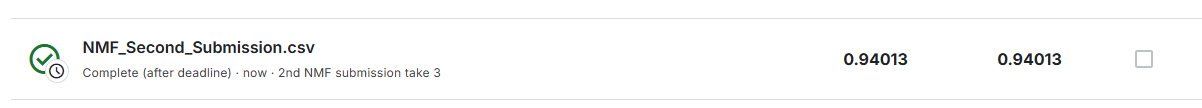


Using only single words as possible ngrams didn't improve the accuracy.

## Compare with supervised learning [30 pts]

Use the following steps to guide your work:

1) Pick and train a supervised learning method(s) and compare the results (train and test performance)
2) Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?


Train accuracy: 1.0
Validation accuracy: 0.9865771812080537


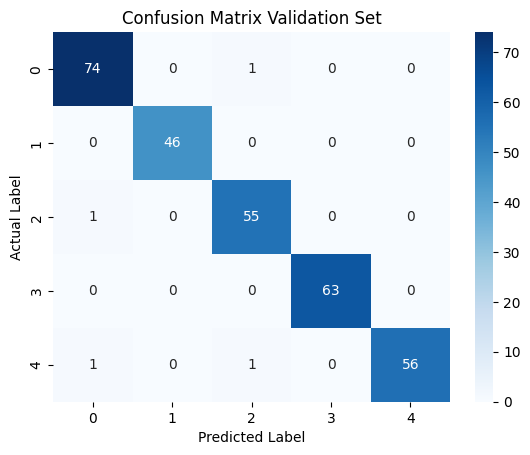

Train accuracy: 1.0
Validation accuracy: 0.9798657718120806


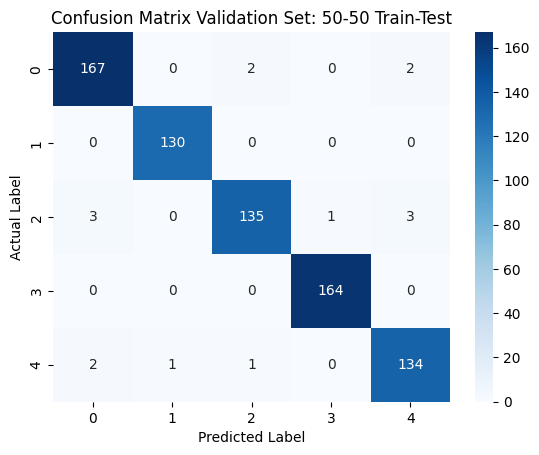

In [ ]:
# Going to apply a logistic regression model to the data using 5 fold cross validation.  Ideal is to help with overfitting.
from sklearn.linear_model import LogisticRegressionCV

# this is for an 80-20 test train split.
features, ngrams, vectorizer_model = word_embeddings(X_train, max_ngrams=1)

log_reg = LogisticRegressionCV(cv=5).fit(features, y_train)
y_pred = log_reg.predict(features)
print("Train accuracy:", accuracy_score(y_train, y_pred))
y_pred_val = log_reg.predict(vectorizer_model.transform(X_val))
print("Validation accuracy:", accuracy_score(y_val, y_pred_val))

conf_matrix = confusion_matrix(y_val, y_pred_val)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Validation Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
# model turned out great, predicting on the val set with 99% accuracy.

# Test with 50-50 test train split.
X_train, X_val, y_train, y_val = train_test_split(train['Text'], train['Category'], test_size=0.5, random_state=42)
features, ngrams, vectorizer_model = word_embeddings(X_train, max_ngrams=1)

log_reg = LogisticRegressionCV(cv=5).fit(features, y_train)
y_pred = log_reg.predict(features)
print("Train accuracy:", accuracy_score(y_train, y_pred))
y_pred_val = log_reg.predict(vectorizer_model.transform(X_val))
print("Validation accuracy:", accuracy_score(y_val, y_pred_val))

conf_matrix = confusion_matrix(y_val, y_pred_val)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Validation Set: 50-50 Train-Test')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Model with only 50% of the data is not as good, but still decent with 98% accuracy.  Because of the cross validation, its not overfitting. 
#  I would guess that you need a lot of data for an nmf model to work.  You could apply a regression model with a lot less data, though it 
#  seems to get better with the more you have.  This is probably due to how sparse the data is.

## Conclusions

Overall it seems that logistic regression with cross validation performs better for this problem.  However, if the labels are not known or just a few are know, nmf gets pretty close from an accuracy perspective.  It would be interesting to try a other types of hyper parameter tuning to see if this gap in accuracy can be closed from .94 of the nmf to the .99 of the logistic regression.  Some things to investigate would be different embedding techniques, or perhaps some ensembling methods using other clustering techniques.

## References
[1] Bijoy Bose. BBC News Classification. https://kaggle.com/competitions/learn-ai-bbc, 2019. Kaggle.

[2] Wikipedia contributors. (2025, January 10). Tf–idf. https://en.wikipedia.org/wiki/Tf%E2%80%93idf

[3] Kachkach, A. (2018, January 10). Problem-solving with ML: automatic document classification. Google Cloud Blog. https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification
